In [812]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
import scipy

# In case need to reload a module or function:
# import sys, importlib
# importlib.reload(sys.modules['stacking'])

# import warnings
# warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# Useful if you are debugging the function inside another .py script
# %load_ext autoreload
# %autoreload 2

In [813]:
pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 85)
%matplotlib inline

In [814]:
house = pd.read_csv('train.csv')
house_test = pd.read_csv('test.csv')

trainSize = house.shape[0]
house.SalePrice = house.SalePrice.apply(np.log)
print(house.shape)
print(house_test.shape)

(1460, 81)
(1459, 80)


In [815]:
# # save the Id column:
train_id = house['Id']
test_id  = house_test['Id']

# Now drop the 'Id' colum 
# since we can not use it as a feature to train our model.
house.drop("Id", axis = 1, inplace = True)
house_test.drop("Id", axis = 1, inplace = True)

In [410]:
# Useful if you are debugging the function inside another .py script
# %load_ext autoreload
# %autoreload 2

# from preprocess import impute

# train_df = pd.read_csv('train.csv')
# test_df  = pd.read_csv('test.csv')

# # save the Id column:
# train_id = train_df['Id']
# test_id  = test_df['Id']

# # Now drop the 'Id' colum 
# # since we can not use it as a feature to train our model.
# train_df.drop("Id", axis = 1, inplace = True)
# test_df.drop("Id", axis = 1, inplace = True)

# y_train = train_df['SalePrice']
# X_train = train_df.drop('SalePrice', axis=1)
# X_test  = test_df.copy()

In [818]:
# distinguish the NA and missing in train data
miss = list(house.columns[house.isnull().sum(axis = 0) >= 1])
miss.remove('LotFrontage')
miss.remove('MasVnrArea')
miss.remove('GarageYrBlt')
miss.remove('MasVnrType')

house.loc[house['MasVnrType'].isnull() == True, 'MasVnrType'] = 'None'
house.loc[house['Electrical'].isnull() == True, 'Electrical'] = 'SBrkr'

for i in range(len(miss)):
    house.loc[house[miss[i]].isnull() == True, miss[i]] = 'NA'    

In [819]:
with open('data_description.txt', 'r') as file:
    lines_level = file.readlines()

In [820]:
feature = ''
levels = {}
level = ''

for line in lines_level:
    if (not not re.findall(': ', line)) and (not re.findall('story:', line)):
#         features.append(re.split(':', line)[0])
        feature = re.split(':', line)[0]
        levels[feature] = []
    else:
        if line != '\n':
#             levels.append(re.split('\t', line)[0].strip())
            level = re.split('\t', line)[0].strip()
            if level != '': levels[feature].append(level)
levels['Id'] = []
levels['SalePrice'] = []
# print(levels)

In [821]:
# find ordinal and none ordinal
with open('DataDocumentation.txt', 'r',encoding='cp1252') as file:
    lines = file.readlines()

In [822]:
nom_lines = []
ord_lines = []
for line in lines:
    if re.findall('(Nominal)', line):
        nom_lines.append(re.sub(' ', '', re.split('\(Nominal\)', line)[0].strip()))
    elif re.findall('(Ordinal)', line):
        ord_lines.append(re.sub(' ', '', re.split('\(Ordinal\)', line)[0].strip()))
print(nom_lines)
print(ord_lines)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1', 'Exterior2', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']


In [823]:
def my_cat(col, levels, ord_lines):
    if not not levels[col.name]: 
        if col.name in ord_lines:
            temp = pd.Categorical(list(col.astype('str')), ordered=True, categories=levels[col.name][::-1])
            temp.name = col.name
            return temp
        else:
            temp = pd.Categorical(list(col.astype('str')), categories=levels[col.name][::-1])
            temp.name = col.name
            return temp
   
    else:
        return col

In [824]:
for col in house:
    house[col] = my_cat(house[col], levels, ord_lines)

In [825]:
miss = list(house_test.columns[house_test.isnull().sum(axis = 0) >= 1])
miss.remove('LotFrontage')
miss.remove('MasVnrArea')
miss.remove('GarageYrBlt')
miss.remove('TotalBsmtSF')
miss.remove('BsmtHalfBath')
miss.remove('BsmtFullBath')
miss.remove('GarageCars')
miss.remove('GarageArea')
miss.remove('BsmtFinSF1')
miss.remove('BsmtFinSF2')
miss.remove('BsmtUnfSF')

house_test.loc[house_test['MasVnrType'].isnull() == True, 'MasVnrType'] = 'CBlock'
house_test.loc[house_test['SaleType'].isnull() == True, 'SaleType'] = 'Oth'
house_test.loc[house_test['Functional'].isnull() == True, 'Functional'] = 'Sal'
house_test.loc[house_test['MSZoning'].isnull() == True, 'MSZoning'] = 'A'
house_test.loc[house_test['Exterior1st'].isnull() == True, 'Exterior1st'] = 'WdShing'
house_test.loc[house_test['Exterior2nd'].isnull() == True, 'Exterior2nd'] = 'Wd Shng'

for i in range(len(miss)):
    house_test.loc[house_test[miss[i]].isnull() == True, miss[i]] = 'NA'

In [826]:
for col in house_test:
    house_test[col] = my_cat(house_test[col], levels, ord_lines)

In [827]:
print(levels['OverallQual'][::-1])
print(levels['ExterQual'][::-1])
print(levels['BsmtQual'][::-1])
print(levels['KitchenQual'][::-1])
print(levels['GarageFinish'][::-1])
print(levels['FireplaceQu'][::-1])
print(levels['HeatingQC'][::-1])

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
['Po', 'Fa', 'TA', 'Gd', 'Ex']
['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
['Po', 'Fa', 'TA', 'Gd', 'Ex']
['NA', 'Unf', 'RFn', 'Fin']
['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
['Po', 'Fa', 'TA', 'Gd', 'Ex']


In [828]:
def OrdinalsToNumerics(all_data):    
    all_data['ExterQual'] = all_data['ExterQual'].map(lambda x: {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
    all_data['BsmtQual'] = all_data['BsmtQual'].map(lambda x: {'NA':1,'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6}.get(x, 0))
    all_data['KitchenQual'] = all_data['KitchenQual'].map(lambda x: {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
    all_data['GarageFinish'] = all_data['GarageFinish'].map(lambda x: {'NA':1, 'Unf':2, 'RFn':3, 'Fin':4}.get(x, 0))
    all_data['FireplaceQu'] = all_data['FireplaceQu'].map(lambda x: {'NA':1,'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6}.get(x, 0))
    all_data['HeatingQC'] = all_data['HeatingQC'].map(lambda x: {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))

    all_data['OverallQual'] = pd.to_numeric(all_data['OverallQual'])
    all_data['ExterQual'] = pd.to_numeric(all_data['ExterQual'])
    all_data['BsmtQual'] = pd.to_numeric(all_data['BsmtQual'])
    all_data['KitchenQual'] = pd.to_numeric(all_data['KitchenQual'])
    all_data['GarageFinish'] = pd.to_numeric(all_data['GarageFinish'])
    all_data['FireplaceQu'] = pd.to_numeric(all_data['FireplaceQu'])
    all_data['HeatingQC'] = pd.to_numeric(all_data['HeatingQC'])
    
def FeatureEngineering(all_data):
    # Adding total sqfootage feature 
    all_data['GarageYrBlt'][all_data['GarageYrBlt'].isnull()] = all_data['YearBuilt'][all_data['GarageYrBlt'].isnull()]
    all_data['GarageYrBlt'] = all_data['GarageYrBlt'] - all_data['YearBuilt']

    #all_data['YrSold'] = all_data['YrSold'] - all_data['YearBuilt']
    
    all_data['MoSold'] = pd.Categorical(list(all_data['MoSold'].astype('str')))
    
    all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

    # GarageYrBlt, GarageArea and GarageCars : Replacing missing data with 0 (Since No garage = no cars in such garage.)
    for col in ('GarageArea', 'GarageCars'):
        all_data[col] = all_data[col].fillna(0)

    # BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : missing values are likely zero for having no basement
    for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
        all_data[col] = all_data[col].fillna(0)

    # LotFrontage : Since the area of each street connected to the house property most likely have a similar 
    # area to other houses in its neighborhood , we can fill in missing values by the median LotFrontage of the neighborhood.
    # Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
    all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    
    all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
    
    # Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.
    all_data = all_data.drop(['Utilities'], axis=1)

drop_cols1 = ["Alley", "ExterCond", "BsmtFinSF2", "Heating", "Electrical",\
              "BsmtHalfBath", "PavedDrive", "Fence", "MiscFeature", "MoSold"]

drop_cols2 = ["BsmtFinType2", "LandContour", "EnclosedPorch",\
              "SaleType", "Functional", "LotConfig",\
              "ScreenPorch", "YrSold", "LandSlope"]

def DropColumns(all_data):
    for col in [*drop_cols1, *drop_cols2]:
        all_data.drop([col], axis=1, inplace=True) 

In [829]:
price = house.SalePrice
house.drop('SalePrice', axis=1, inplace=True)

#house_all = pd.concat([house.iloc[:, :-1], house_test], ignore_index = True)
#house = house_all.copy()

#house.info()
#house.isnull().sum()
#house_all.shape

In [830]:
# https://stackoverflow.com/questions/46749037/can-i-use-train-and-test-data-for-imputation
# Should not use both train and test data for imputation.
# use train data only for train data imputation. 
OrdinalsToNumerics(house)
OrdinalsToNumerics(house_test)

FeatureEngineering(house)
FeatureEngineering(house_test)

# As found in testing, dropping the two sets of columns I provided before, one set at a time. 
# My finding is that: drop unimportant columns will generally improve the linear model performance 
# (linear/Ridge/Lasso/ElasticNet), while w/o any re-tuning, 
# RF and GBM performance dropped a little bit, but not much. 
# If do careful re-tuning, would be very likely similar as before as I feel. 
#Next, I'm going to re-tune the GBM and RF for the reduced set of features, and see...
DropColumns(house)
DropColumns(house_test)

C:\Users\yh23\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [568]:
# def year_eng(data, year_1, year_2, year_out):
#     data[year_out] = data[year_1] - data[year_2]
#     data[year_out][data[year_out].isnull()] = 0
# year_eng(house, 'GarageYrBlt', 'YearBuilt', 'Garage-Built')
# house.drop(['GarageYrBlt'], axis = 1, inplace = True)

# numeric_cols = house.describe().transpose().index
# print(numeric_cols)

# from fancyimpute import KNN
# house[numeric_cols] = KNN(k = int(math.sqrt(house.shape[0]))).complete(house[numeric_cols])

In [831]:
# use one hot encoding for all the categorical variables/columns:
all_data = pd.concat([house, house_test], ignore_index = True)
all_data = pd.get_dummies(all_data, drop_first=True)

In [832]:
train_clean = all_data.iloc[:trainSize,:]
train_clean = train_clean.assign(SalePrice = price.values)
train_clean.shape
#train_clean.describe().transpose()
#train_clean.isnull().sum()
#train_clean.info()
#train_clean.to_csv('train_clean.csv', index=False)

(1460, 219)

In [833]:
trainSize

1460

In [834]:
test_clean = all_data.iloc[trainSize:, :]
test_clean.shape
#test_clean.info()
#test_clean.isnull().sum()
#test_clean.to_csv('test_clean.csv', index = False)

(1459, 218)

In [835]:
#---------- Model work start here -------------
import numpy as np
import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor #as gbr as rfr

from sklearn.metrics import mean_squared_error

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [836]:
rs_const = 80 #always use the same one value for all model tuning process
test_ratio_const = 0.2 

train_data   = train_clean.drop('SalePrice', axis=1)
train_target = train_clean[['SalePrice']]
test_data    = test_clean

X_train, X_test, y_train, y_test = train_test_split(train_data, train_target,\
                                                    test_size=test_ratio_const, random_state=rs_const)

We found that: linear models got ~+0.12 RMSE incr for random_state=0 vs 80, while GBM, RF only got about ~+0.02 incr. But this is w/o re-tune the GBM, and RF for new data. If re-tuned, there will be less incr finally... Because this is a very small data set train data 1460 rows, a 0.2 vs 0.8 split may affect the result a lot. I think these results are reasonable, and we can just take what ever we find the best result to go for the final submission test.

Also, I think more emphasis/focus should be put on effective feature engineering, than model tuning, as the proven effective feature engineering changes will surely benefit in general, and should much less affected by particular data split.

In [837]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std  = scaler.transform(X_test)

In [838]:
# 1. linear regression:
model = linear_model.LinearRegression()
model.fit(X_train, y_train)

print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

RMSE train: 0.10262489450225754
RMSE test : 0.12730969435646072


Linear regression:
RMSE train: 0.09435834578466382
RMSE test : 0.13085211247876494

After feature engineering: 
RMSE train: 0.10262489450225754
RMSE test : 0.12730969435646072

In [839]:
# 2. ridge
grid_param = [{'alpha': np.logspace(-4, 4, 20)}]

gs = GridSearchCV(estimator=linear_model.Ridge(random_state=rs_const), param_grid=grid_param, cv=5)

gs.fit(X_train_std, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train_std))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test_std))))

# Best params: {'alpha': 545.5594781168514}
# Best score : 0.8654132064806032
# RMSE train: 0.10934351842121603
# RMSE test : 0.10190304727025887

# Best params: {'alpha': 545.5594781168514}
# Best score : 0.862816990220294
# RMSE train: 0.11500081056347174
# RMSE test : 0.0996716927282455

Best params: {'alpha': 545.5594781168514}
Best score : 0.862816990220294
RMSE train: 0.11500081056347175
RMSE test : 0.09967169272824544


In [755]:
pd.Series(model.coef_.flatten()).describe()

count    218.000000
mean       0.001802
std        0.008447
min       -0.038079
25%       -0.001980
50%        0.000349
75%        0.004463
max        0.037733
dtype: float64

In [857]:
# 3. lasso 
# max_iter = 1000, if not enough better increase alpha to proceed, 
# but not increase max_iter, as it mostly won't help much on the slow convergence. 
grid_param = [{'alpha': np.logspace(-3, 4, 20)}] 

gs = GridSearchCV(estimator=linear_model.Lasso(random_state=rs_const, normalize=False), param_grid=grid_param, cv=5)

gs.fit(X_train_std, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train_std))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test_std))))

# when normalize=True of Lasso():
# RMSE train: 0.1625867826007739
# RMSE test : 0.13398889867056274

# when standardizing the Xs: 
# RMSE train: 0.10967089420036176
# RMSE test : 0.09713326027456916

# Best params: {'alpha': 0.00545559478116852}
# Best score : 0.8564711534949876
# RMSE train: 0.11402145996484199
# RMSE test : 0.09659128729814825

# Best params: {'alpha': 0.004832930238571752}
# Best score : 0.8570699987570224
# RMSE train: 0.11276299232919795
# RMSE test : 0.09615925751559042

Best params: {'alpha': 0.00545559478116852}
Best score : 0.8564711534949876
RMSE train: 0.11402145996484199
RMSE test : 0.09659128729814825


In [858]:
# for best alpha Lasso, only 21% features left/used for modeling. Wow! Really awesome.
sum(model.coef_ > 1e-6) / model.coef_.shape[0]

0.21100917431192662

In [853]:
# 4. ElasticNet
grid_param = [{'alpha': np.logspace(-2, 4, 20), 'l1_ratio': np.linspace(0.015, 1, 20)}]

# Confirmed that setting scoring='neg_mean_squared_error' is the same result as using the default "R2" score.
gs = GridSearchCV(estimator=linear_model.ElasticNet(random_state=rs_const), param_grid=grid_param, cv=5)

gs.fit(X_train_std, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train_std))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test_std))))

# Best params: {'alpha': 0.37926901907322497, 'l1_ratio': 0.015}
# Best score : 0.8697971068269247
# RMSE train: 0.11959798312806508
# RMSE test : 0.10159470637810745

# Best params: {'alpha': 0.18329807108324356, 'l1_ratio': 0.015}
# Best score : 0.8652189389746141
# RMSE train: 0.11276554450715622
# RMSE test : 0.09558444759984833

Best params: {'alpha': 0.18329807108324356, 'l1_ratio': 0.015}
Best score : -0.022066159875477977
RMSE train: 0.11276554450715622
RMSE test : 0.09558444759984833


In [856]:
sum(model.coef_ > 1e-6) / model.coef_.shape[0]

0.3165137614678899

In [842]:
# 5. GBM

#https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# GradientBoostingClassifier

# Step 
#learning_rate = 0.1, golden: 0.05~0.2 def 0.1
#n_estimators=100,    golden: 40~70 def 100
#subsample=1.0, 0.6-0.7~0.9 +0.05, usu ~0.8      
#------
#max_depth=3, 5~8 
#min_samples_split=2, ~0.5~1% of n total observations n/400~n/80 search 
#min_samples_leaf=1, 1<= < min_samples_split 
#max_features=None, 'sqrt', 30~40% total features 
#------
#warm_start=False
#scoring='roc_auc', iid=False,...

# Step 
#grid_param = [{'n_estimators':range(10,81,10)}] # 140
#grid_param = [{'n_estimators':range(80,201,20)}] # 140

# Step 
#grid_param = [{'max_depth':range(5,16,2), 'min_samples_split':range(3,21,3)}] #5, 9
#grid_param = [{'min_samples_split':np.arange(3,30,2)}] 
#grid_param = [{'min_samples_leaf':np.arange(1,10,1)}] # 3, 28
#grid_param = [{'max_features':np.arange(3,154,10)}] # 63 #'sqrt': 16.33
#grid_param = [{'max_features':np.arange(3,51,5)}] 

# Step
#grid_param = [{'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}] # 0.8

grid_param = [{}]

# Step
#learning_rate:0.1 -> 0.05 -> 0.01 -> 0.005 ->... 0.005 best
#n_estimators: 140 -> 280  -> 1000 -> 2000  ->... 3000 best

gs = GridSearchCV(estimator = GradientBoostingRegressor(\
                                    learning_rate=0.005,\
                                    n_estimators=3000,\
                                    max_depth=5,\
                                    min_samples_split=7,\
                                    min_samples_leaf=1,\
                                    max_features='sqrt',\
                                    subsample=0.8,\
                                    random_state=rs_const), \
                                    param_grid = grid_param,\
                                    n_jobs=4, cv=5)  

gs.fit(X_train, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

#varImp = pd.Series(model.feature_importances_, X_train.columns.ravel()).sort_values(ascending=False)
#varImp.plot(kind='bar', title='Feature Importances')
#plt.ylabel('Feature Importance Score')

# Best params: {}
# Best score : 0.8984484354121561
# RMSE train: 0.05370993436312855
# RMSE test : 0.10634295917930285

# Best params: {} learning_rate=0.005, n_estimators=3000 ----> best
# Best score : 0.8996931143172933
# RMSE train: 0.04888394557583896
# RMSE test : 0.09757180528938497

C:\Users\yh23\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params: {}
Best score : 0.8996931143172933
RMSE train: 0.04888394557583896
RMSE test : 0.09757180528938497


In [860]:
# Step
#learning_rate:0.1 -> 0.05 -> 0.01 -> 0.005 ->... 0.005 best
#n_estimators: 140 -> 280  -> 1000 -> 2000  ->... 3000 best

model = GradientBoostingRegressor(\
                                    learning_rate=0.005,\
                                    n_estimators=3000,\
                                    max_depth=5,\
                                    min_samples_split=7,\
                                    min_samples_leaf=1,\
                                    max_features='sqrt',\
                                    subsample=0.8,\
                                    random_state=rs_const)
model.fit(X_train, y_train)

print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

# RMSE train: 0.04888394557583896
# RMSE test : 0.09757180528938497

C:\Users\yh23\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RMSE train: 0.04888394557583896
RMSE test : 0.09757180528938497


In [712]:
print('sqrt total feature: {}'.format(math.sqrt(X_train.columns.shape[0])))
print('40% of total feature: {}'.format(X_train.columns.shape[0] * 0.4))

sqrt total feature: 14.7648230602334
40% of total feature: 87.2


C:\Users\yh23\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


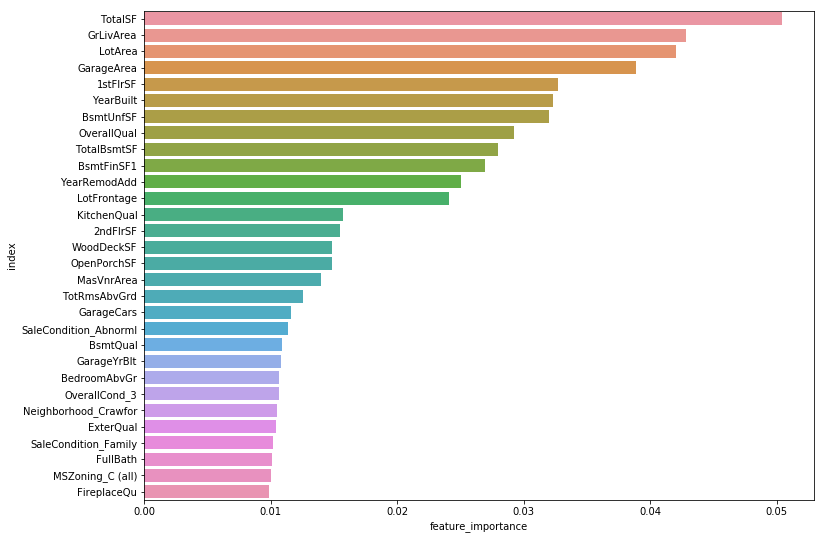

In [865]:
varImp = pd.DataFrame({'index':X_train.columns, 'feature_importance':model.feature_importances_})
varImp.sort_values(by='feature_importance', ascending=False, inplace=True)
f, ax = plt.subplots(1, 1, figsize=[12, 9])
sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:30,], ax = ax)

# fig = sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:30,], ax = ax).figure
# ax.set_title('Top 30 Features from GBM')
# fig.savefig('feature_importance_top30_GBM.png', bbox_inches='tight')   # save the figure to file
# plt.close(fig)

# f, (ax1, ax2) = plt.subplots(1, 2, figsize=[12, 9])
# sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:30,], ax = ax1)
# tmp = varImp.iloc[-1:-50:-1,]
# sns.barplot(x = 'feature_importance', y = 'index', data = tmp, ax = ax2)

In [866]:
# 6. RF

#RandomForestRegressor(
#max_features=’auto’, 
#n_estimators=10, 

#min_samples_split=2, 
#min_samples_leaf=1,

#n_jobs=1, 
#random_state=None, 
#verbose=0, 
#warm_start=False

# Step
#grid_param = [{'n_estimators':[5, *range(10, 201, 20)]}] # 170 --> 90
#grid_param = [{'n_estimators':range(100, 1001, 50)}]

#grid_param = [{'max_features':[*range(10,30,5), *range(40, 141, 20)]}] # 80, 170 --> 140
grid_param = [{}] #5, *range(10, 201, 20)]}] # 190

#grid_param = [{'max_features':range(10, 150, 20)}]
#grid_param = [{'n_estimators':range(50, 501, 50)}] # 170 --> 90

#grid_param = [{"min_samples_split":range(5, 41, 3), "min_samples_leaf":range(1,6)}]

gs = GridSearchCV(estimator = RandomForestRegressor(\
                                    max_features=70,\
                                    n_estimators=200,\
                                    min_samples_split=5,\
                                    min_samples_leaf=1,\
                                    random_state=rs_const,\
                                    n_jobs=-1),\
                  param_grid = grid_param, n_jobs=-1, cv=5)  

gs.fit(X_train, y_train)

#cv_results_, grid_scores_ (to obsolete), best_estimator_, best_params_, best_score_
print('Best params: {}'.format(gs.best_params_))
print('Best score : {}'.format(gs.best_score_))
#print('')
model = gs.best_estimator_
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

#display(model)
#varImp = pd.Series(model.feature_importances_, X_train.columns.ravel()).sort_values(ascending=False)
#varImp.plot(kind='bar', title='Feature Importances')
#plt.ylabel('Feature Importance Score')

# Best params: {}
# Best score : 0.8684275221502107
# RMSE train: 0.05395604264569257
# RMSE test : 0.11215522717332425

# Best params: {'min_samples_leaf': 1, 'min_samples_split': 5}
# Best score : 0.8762657458758624
# RMSE train: 0.0624176501584567
# RMSE test : 0.1155096809014261

C:\Users\yh23\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best params: {}
Best score : 0.8762657458758625
RMSE train: 0.06241765015845673
RMSE test : 0.11550968090142612


In [725]:
display(model)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=70, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=80,
           verbose=0, warm_start=False)

C:\Users\yh23\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


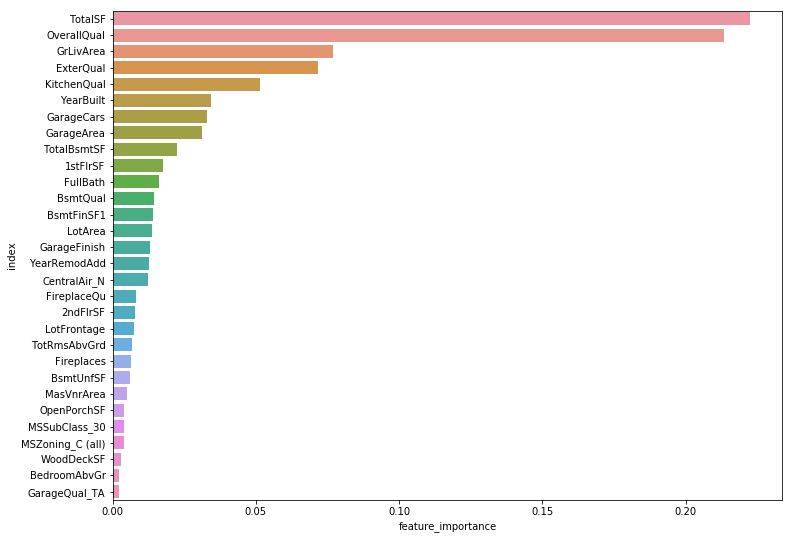

In [868]:
varImp = pd.DataFrame({'index':X_train.columns, 'feature_importance':model.feature_importances_})
varImp.sort_values(by='feature_importance', ascending=False, inplace=True)
f, ax = plt.subplots(1, 1, figsize=[12, 9])
sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:30,], ax = ax)

# fig = sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:30,], ax = ax).figure
# ax.set_title('Top 30 Features from Random Forest')
# fig.savefig('feature_importance_top30_RF.png', bbox_inches='tight')   # save the figure to file
# plt.close(fig)

C:\Users\yh23\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RMSE train: 0.06241765015845671
RMSE test : 0.11550968090142603


C:\Users\yh23\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


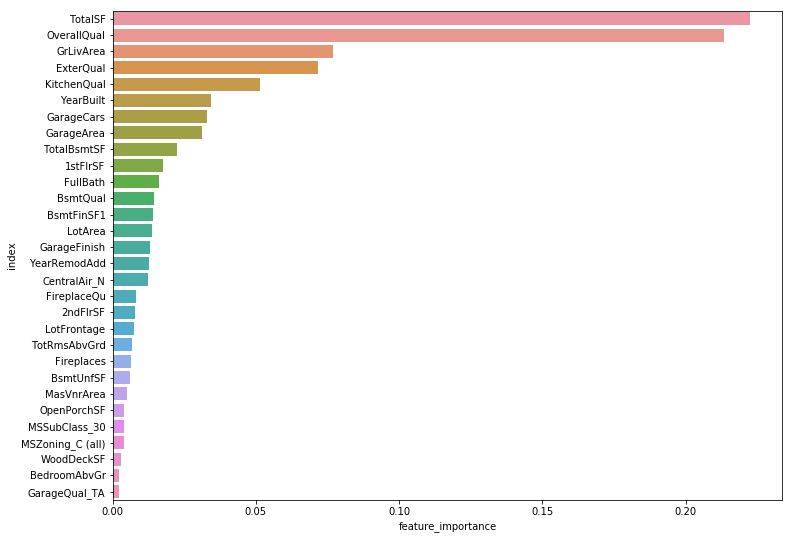

In [727]:
# RF best/try:
model = RandomForestRegressor(\
            max_features=70,\
            n_estimators=200,\
            min_samples_split=5,\
            min_samples_leaf=1,\
            random_state=rs_const,\
            n_jobs=-1)

model.fit(X_train, y_train)
print("RMSE train: {}".format(rmse(y_train, model.predict(X_train))))
print("RMSE test : {}".format(rmse(y_test,  model.predict(X_test))))

varImp = pd.DataFrame({'index':X_train.columns, 'feature_importance':model.feature_importances_})
varImp.sort_values(by='feature_importance', ascending=False, inplace=True)
f, ax = plt.subplots(1, 1, figsize=[12, 9])
sns.barplot(x = 'feature_importance', y = 'index', data = varImp.iloc[:30,], ax = ax)

In [306]:
dir(model)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_estimator_type',
 '_get_param_names',
 '_make_estimator',
 '_set_oob_score',
 '_validate_X_predict',
 '_validate_estimator',
 '_validate_y_class_weight',
 'apply',
 'base_estimator',
 'base_estimator_',
 'bootstrap',
 'class_weight',
 'criterion',
 'decision_path',
 'estimator_params',
 'estimators_',
 'feature_importances_',
 'fit',
 'get_params',
 'max_depth',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impuri

In [768]:
# check the actual max_depth of each decision tree from RF:
np.array([estimator.tree_.max_depth for estimator in model.estimators_])

array([25, 20, 19, 26, 17, 18, 20, 19, 21, 18, 23, 19, 19, 20, 26, 23, 17,
       19, 18, 20, 25, 20, 20, 21, 19, 17, 20, 19, 22, 20, 19, 23, 19, 21,
       18, 19, 17, 20, 18, 23, 19, 21, 21, 17, 18, 22, 19, 22, 19, 22, 18,
       18, 19, 22, 22, 23, 18, 18, 21, 19, 18, 18, 20, 19, 19, 20, 20, 19,
       18, 19, 20, 20, 21, 19, 19, 19, 19, 18, 19, 19, 20, 26, 21, 17, 20,
       18, 20, 18, 21, 18, 20, 17, 19, 18, 17, 21, 16, 18, 21, 23, 21, 22,
       20, 18, 18, 18, 20, 21, 19, 19, 23, 16, 21, 19, 21, 18, 24, 19, 18,
       20, 18, 20, 23, 23, 18, 20, 17, 23, 19, 18, 21, 20, 20, 17, 19, 21,
       19, 22, 17, 20, 19, 27, 18, 19, 19, 19, 19, 23, 17, 20, 18, 18, 19,
       22, 20, 21, 18, 18, 19, 20, 18, 22, 20, 20, 21, 17, 18, 17, 20, 17,
       20, 18, 17, 19, 18, 19, 16, 20, 18, 19, 19, 22, 21, 17, 20, 20, 18,
       21, 23, 17, 19, 17, 16, 18, 18, 16, 20, 23, 16, 21])

Linear regression:
RMSE train: 0.10262489450225754
RMSE test : 0.12730969435646072

Ridge:
RMSE train: 0.11500081056347174
RMSE test : 0.0996716927282455

Lasso:
RMSE train: 0.11276299232919795
RMSE test : 0.09615925751559042
    
ElasticNet:
RMSE train: 0.11276554450715622
RMSE test : 0.09558444759984833  ---> best single model: improved by feature engineering

GBM:
RMSE train: 0.04888394557583896
RMSE test : 0.09757180528938497 ---> improved by feature engineering
    
RF:
RMSE train: 0.0624176501584567
RMSE test : 0.1155096809014261 ---> degrade a little bit ~0.003

In [880]:
model_df = pd.DataFrame({'OLS':[0.1026, 0.1273],\
                        'Ridge':[0.1150, 0.0998],\
                        'Lasso':[0.1128, 0.0962],\
                        'ElasticNet':[0.1128, 0.0956],\
                        'GBM':[0.0489, 0.0976],\
                        'RF':[0.0624, 0.1155],\
                        'Stacked':[0.0635, 0.0973]},\
                        columns=['OLS','Ridge','Lasso','ElasticNet','GBM','RF', 'Stacked'],\
                        index=['RMSE Training', 'RMSE Testing'])
model_df

,OLS,Ridge,Lasso,ElasticNet,GBM,RF,Stacked
RMSE Training,0.1026,0.1150,0.1128,0.1128,0.0489,0.0624,0.0635
RMSE Testing,0.1273,0.0998,0.0962,0.0956,0.0976,0.1155,0.0973


In [844]:
# Useful if you are debugging the function inside another .py script
# %load_ext autoreload
# %autoreload 2

import sys, importlib
importlib.reload(sys.modules['stacking'])

from stacking import stacking_regression

In [845]:
# best multi model stacking: 
models = [
    # linear model
    #linear_model.Lasso(alpha=0.00545559478116852, random_state=rs_const),
    linear_model.ElasticNet(alpha=0.18329807108324356, l1_ratio=0.015, random_state=rs_const),
 
    # conservative random forst model
#     RandomForestRegressor(\
#                         max_depth=5,\
#                         max_features='sqrt',\
#                         n_estimators=1000,\
#                         random_state=rs_const,\
#                         n_jobs=-1),
    
    RandomForestRegressor(\
                        max_features=70,\
                        n_estimators=200,\
                        min_samples_split=5,\
                        min_samples_leaf=1,\
                        random_state=rs_const,\
                        n_jobs=-1),
#     RandomForestRegressor(\
#                         max_depth=None,\
#                         max_features=80,\
#                         n_estimators=170,\
#                         random_state=rs_const,\
#                         n_jobs=-1),
    
    # conservative gbm model
#     GradientBoostingRegressor(\
#                         learning_rate=0.005,\
#                         n_estimators=3000,\
#                         max_depth=2,\
#                         min_samples_split=40,\
#                         min_samples_leaf=10,\
#                         max_features=120,\
#                         subsample=0.8,\
#                         random_state=rs_const),
    
    GradientBoostingRegressor(\
                        learning_rate=0.005,\
                        n_estimators=3000,\
                        max_depth=5,\
                        min_samples_split=7,\
                        min_samples_leaf=1,\
                        max_features='sqrt',\
                        subsample=0.8,\
                        random_state=rs_const)
    
#     GradientBoostingRegressor(\
#                         learning_rate=0.01,\
#                         n_estimators=2000,\
#                         max_depth=5,\
#                         min_samples_split=28,\
#                         min_samples_leaf=3,\
#                         max_features=63,\
#                         subsample=0.8,\
#                         random_state=rs_const)
    ]

meta_model = linear_model.LinearRegression(normalize=False) # normalize=True: almost the same

# For log sale price: 
# RMSE train: 0.0639554336207892
# RMSE test : 0.09745492039582548

# For actual sale price: 
# RMSE train: 11982.802272179102
# RMSE test : 17811.996531507833
# Wall time: 28.1 s

In [459]:
# Zeyu's lecture code:
models = [
    # linear model, ElasticNet = lasso + ridge
    ElasticNet(random_state=rs_const),
    
    # conservative random forst model
    RandomForestRegressor(random_state=rs_const,
        n_estimators=1000, max_depth=6,  max_features='sqrt'),
    
    # aggressive random forst model
    RandomForestRegressor(random_state=rs_const, 
        n_estimators=1000, max_depth=9,  max_features='auto'),
    
    # conservative gbm model
    GradientBoostingRegressor(random_state=rs_const, learning_rate = 0.005, max_features='sqrt',
        min_samples_leaf=15, min_samples_split=10, 
        n_estimators=3000, max_depth=3),
    
    # aggressive gbm model
    GradientBoostingRegressor(random_state = rs_const, learning_rate = 0.01, max_features='sqrt',
        min_samples_leaf=10, min_samples_split=5, 
        n_estimators = 1000, max_depth = 9)
    ]

meta_model = linear_model.LinearRegression(normalize=True)

# For log sale price: 
# RMSE train: 0.06345289301880326
# RMSE test : 0.0972510347548843

# For actual sale price: 
# RMSE train: 11878.195890627157
# RMSE test : 18107.13086176243
# Wall time: 17.9 s

In [846]:
%%time 
final_train_prediction = stacking_regression(models, meta_model, X_train_std, y_train, X_train_std,
                               transform_target=None, transform_pred=None,                                        
                               metric=rmse, verbose=0, random_state=rs_const)

final_test_prediction = stacking_regression(models, meta_model, X_train_std, y_train, X_test_std,
                               transform_target=None, transform_pred=None,                                        
                               metric=rmse, verbose=0, random_state=rs_const)

print("For log sale price: ")
print("RMSE train: {}".format(rmse(y_train, final_train_prediction)))
print("RMSE test : {}".format(rmse(y_test,  final_test_prediction)))
print("")
print("For actual sale price: ")
print("RMSE train: {}".format(rmse(np.expm1(y_train), np.expm1(final_train_prediction))))
print("RMSE test : {}".format(rmse(np.expm1(y_test),  np.expm1(final_test_prediction))))

D:\2018-DSBootCamp\mlProj\final\stacking.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Predict out-of-fold part of train set
D:\2018-DSBootCamp\mlProj\final\stacking.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Predict out-of-fold part of train set
D:\2018-DSBootCamp\mlProj\final\stacking.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Predict out-of-fold part of train set
C:\Users\yh23\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True

For log sale price: 
RMSE train: 0.06345289301880316
RMSE test : 0.09725103475488424

For actual sale price: 
RMSE train: 11878.195890627141
RMSE test : 18107.130861762435
Wall time: 20.9 s


In [772]:
%%time 
# Single model selection: best Lasso:
model = linear_model.ElasticNet(alpha=0.18329807108324356, l1_ratio=0.015, random_state=rs_const)

model.fit(X_train_std, y_train)

final_train_prediction = model.predict(X_train_std)
final_test_prediction  = model.predict(X_test_std)

print("For log sale price: ")
print("RMSE train: {}".format(rmse(y_train, final_train_prediction)))
print("RMSE test : {}".format(rmse(y_test,  final_test_prediction)))
print("")
print("For actual sale price: ")
print("RMSE train: {}".format(rmse(np.expm1(y_train), np.expm1(final_train_prediction))))
print("RMSE test : {}".format(rmse(np.expm1(y_test),  np.expm1(final_test_prediction))))

For log sale price: 
RMSE train: 0.11276554450715622
RMSE test : 0.09558444759984833

For actual sale price: 
RMSE train: 22829.5646198827
RMSE test : 17314.53239695407
Wall time: 21 ms


Best single model selection: best ElasticNet --> best accuracy 
-----------------------------------------------
For log sale price: 
RMSE train: 0.11276554450715622
RMSE test : 0.09558444759984833 --> improved by feature engineering

For actual sale price: 
RMSE train: 22829.5646198827
RMSE test : 17314.53239695407
Wall time: 24.1 ms

Best multi model stacking: best ElasticNet + best RF + best GBM ---> go for final submission: robust
------------------------------------------------------------------
For log sale price: 
RMSE train: 0.06345289301880326
RMSE test : 0.0972510347548843 --> improved by feature engineering

For actual sale price: 
RMSE train: 11878.195890627157
RMSE test : 18107.13086176243
Wall time: 17.9 s

Feature engineering improves the overall model performance:
--------------------------------------------------------------
After dropping the two sets of columns, my results are as follows: linear models all improves, GBM improves, RF degrades a little bit. Overall, both the best single model (ElasticNet) and the (ElasticNet+GBM+RF) stacking model are improved. So, for me, the conclusions is that: after feature engineering, the model performance is improved.

Zeyu's no-tune multi-model stacking:
-------------------------------------
For log sale price: 
RMSE train: 0.077909628475195
RMSE test : 0.10344003053409413

For actual sale price: 
RMSE train: 15733.404194715245
RMSE test : 19329.12467936738
Wall time: 1min 28s

In [847]:
# Final submission: 
# fit model using full training data set, and generate prediction w/ full test set: 

scaler = StandardScaler()
scaler.fit(train_data)

train_data_std = scaler.transform(train_data)
test_data_std  = scaler.transform(test_data)

In [848]:
%%time 
final_train_prediction = stacking_regression(models, meta_model, train_data_std, train_target, train_data_std,
                               transform_target=None, transform_pred=None,                                        
                               metric=rmse, verbose=0, random_state=rs_const)

final_test_prediction = stacking_regression(models, meta_model, train_data_std, train_target, test_data_std,
                               transform_target=None, transform_pred=None,                                        
                               metric=rmse, verbose=0, random_state=rs_const)

print("For log sale price: ")
print("RMSE train: {}".format(rmse(train_target, final_train_prediction)))
print("")
print("For actual sale price: ")
print("RMSE train: {}".format(rmse(np.expm1(train_target), np.expm1(final_train_prediction))))

# For log sale price: 
# RMSE train: 0.06533303703288473

# For actual sale price: 
# RMSE train: 11932.660673178556
# Wall time: 22.5 s

D:\2018-DSBootCamp\mlProj\final\stacking.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Predict out-of-fold part of train set
D:\2018-DSBootCamp\mlProj\final\stacking.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Predict out-of-fold part of train set
D:\2018-DSBootCamp\mlProj\final\stacking.py:144: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Predict out-of-fold part of train set
C:\Users\yh23\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True

For log sale price: 
RMSE train: 0.06533303703288473

For actual sale price: 
RMSE train: 11932.66067317856
Wall time: 25.1 s


In [854]:
# Also tried final submission of best single model: Kaggle score is worse than stacked model.

model = linear_model.ElasticNet(alpha=0.18329807108324356, l1_ratio=0.015, random_state=rs_const)

model.fit(train_data_std, train_target)

final_train_prediction = model.predict(train_data_std)
final_test_prediction  = model.predict(test_data_std)

print("For log sale price: ")
print("RMSE train: {}".format(rmse(train_target, final_train_prediction)))
print("")
print("For actual sale price: ")
print("RMSE train: {}".format(rmse(np.expm1(train_target), np.expm1(final_train_prediction))))

For log sale price: 
RMSE train: 0.10976180389854766

For actual sale price: 
RMSE train: 22028.167960626895


In [855]:
# Generate final submission file to Kaggle:

final_test_prediction = np.expm1(final_test_prediction)

final_submission = pd.DataFrame()
final_submission['Id'] = test_id
final_submission['SalePrice'] = final_test_prediction

final_submission.to_csv('Boost5_submission.csv', index=False)

In [850]:
final_submission

,Id,SalePrice
0,1461,122418.082003
1,1462,159673.906254
2,1463,189390.798792
3,1464,197036.732378
4,1465,186000.229992
5,1466,178109.643508
6,1467,172818.553929
7,1468,167873.410107
8,1469,181266.598315
9,1470,124685.218263


In [851]:
check_submission = pd.read_csv('Boost5_submission.csv')

In [852]:
check_submission

,Id,SalePrice
0,1461,122418.082003
1,1462,159673.906254
2,1463,189390.798792
3,1464,197036.732378
4,1465,186000.229992
5,1466,178109.643508
6,1467,172818.553929
7,1468,167873.410107
8,1469,181266.598315
9,1470,124685.218263
